In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
names = ['ID', 'Xcor','Ycor', 'F606','eF606','F814','eF814','chi','sharp']
df_stars = pd.read_csv('../../Report1/Data/Catalog/hlsp_deep47tuc_hst_acs_47tuc_f606w-f814w_v1_catalog.txt', 
                      names=names, delim_whitespace=True, skiprows=1)
df_stars.head()

,ID,Xcor,Ycor,F606,eF606,F814,eF814,chi,sharp
0,8,4462.947,140.859,28.197,0.1036,27.127,0.1068,6.106,0.7310
1,120,5002.486,186.138,20.843,0.0552,19.815,0.0661,10.690,0.4000
2,165,5003.574,195.421,27.014,0.2194,26.068,0.1349,10.651,0.1940
3,226,4448.493,207.417,30.193,0.3641,28.270,0.1636,4.059,-1.9585
4,351,5040.717,224.366,28.935,0.1669,28.941,0.2464,4.274,-0.7720


# Visualize Data

Text(0, 0.5, 'F814')

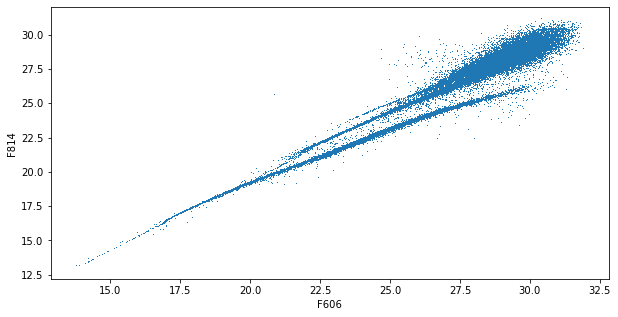

In [3]:
plt.figure(figsize=(10,5))
plt.plot(df_stars.F606, df_stars.F814, ',')
plt.xlabel('F606')
plt.ylabel('F814')

# Standardization

In [41]:
df = df_stars[['F606', 'F814', 'chi', 'sharp']].copy()

x = df.F606 - df.F814
y = 16.5 + 4. * x
df.loc[df.F814 <= y, 'class'] = 0
df.loc[df.F814 > y, 'class'] = 1

data = df.to_numpy()[:, :-1]
true_labels = df['class'].to_numpy()


df.head()

,F606,F814,chi,sharp,class
0,28.197,27.127,6.106,0.7310,1.0
1,20.843,19.815,10.690,0.4000,0.0
2,27.014,26.068,10.651,0.1940,1.0
3,30.193,28.270,4.059,-1.9585,1.0
4,28.935,28.941,4.274,-0.7720,1.0


In [42]:
n_clusters = len(df['class'].unique())


# preprocessing pipeline will implement the PCA class to perform dimensionality reduction
# MinMaxScaler: do not assume that the shape of all your features follows a normal distribution
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)


# k-means clustering pipeline with user-defined arguments in the KMeans constructor
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               n_jobs=-1,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)


pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [43]:
pipe.fit(data)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=2, random_state=42,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=500,
                                         n_clusters=2, n_init=50, n_jobs=-1,
                                         precomput

In [44]:
%%time

preprocessed_data = pipe["preprocessor"].transform(data)
predicted_labels = pipe["clusterer"]["kmeans"].labels_

Wall time: 5 ms


In [45]:
%%time

print(silhouette_score(preprocessed_data, predicted_labels))
print(adjusted_rand_score(true_labels, predicted_labels))

0.634208137831066
0.6572528877686576
Wall time: 30.6 s


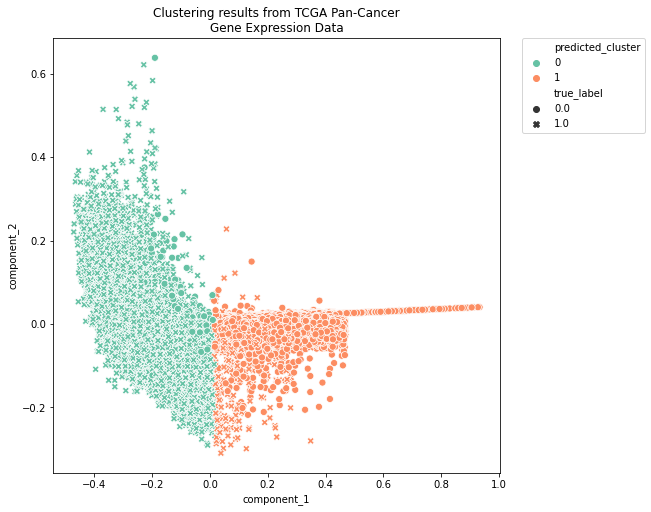

In [46]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = df['class']

plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [47]:
df['predicted_labels'] = predicted_labels

In [52]:
df

,F606,F814,chi,sharp,class,predicted_labels
0,28.197,27.127,6.106,0.7310,1.0,0
1,20.843,19.815,10.690,0.4000,0.0,1
2,27.014,26.068,10.651,0.1940,1.0,0
3,30.193,28.270,4.059,-1.9585,1.0,0
4,28.935,28.941,4.274,-0.7720,1.0,0
...,...,...,...,...,...,...
51475,26.895,25.602,9.508,1.3140,1.0,0
51476,23.152,22.662,8.823,-0.1330,1.0,1
51477,27.209,27.130,4.311,0.9355,1.0,0
51478,28.235,26.477,6.173,0.3190,1.0,0


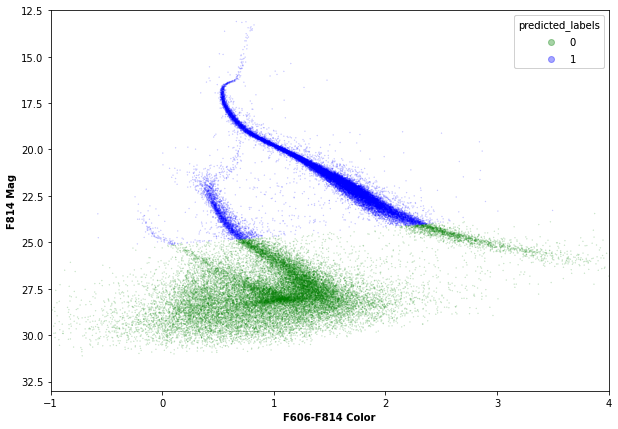

In [51]:
fig, ax = plt.subplots(figsize=(10,7))
scatter = plt.scatter(x, df.F814, c=df['predicted_labels'], alpha=.3, s=0.1, cmap=ListedColormap(['g', 'b']))
plt.xlim(-1, 4)
plt.ylim(33, 12.5)
plt.xlabel('F606-F814 Color', weight='bold')
plt.ylabel('F814 Mag', weight='bold')

legend = ax.legend(*scatter.legend_elements(), title="predicted_labels")
ax.add_artist(legend)

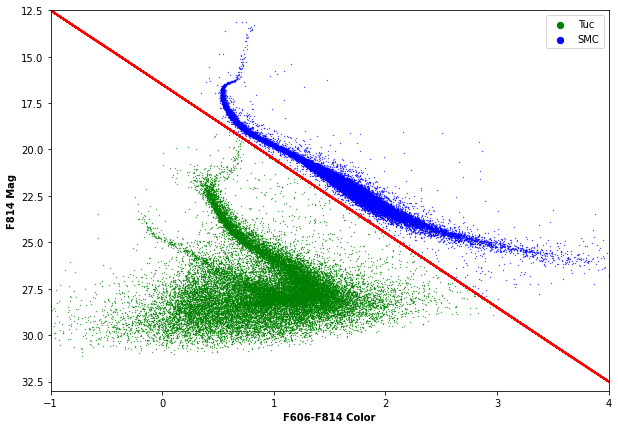

In [49]:
x = df.F606 - df.F814
y = 16.5 + 4. * x
plt.figure(figsize=(10,7))
plt.plot(x, y, '-r')

Tuc = df.F814 > y
SMC = df.F814 < y

plt.scatter(x[Tuc], df.loc[Tuc, 'F814'], s=0.1, c='g', label='Tuc')
plt.scatter(x[SMC], df.loc[SMC, 'F814'], s=0.1, c='b', label='SMC')

plt.xlim(-1, 4)
plt.ylim(33, 12.5)
plt.xlabel('F606-F814 Color', weight='bold')
plt.ylabel('F814 Mag', weight='bold')
plt.legend(markerscale=20);

# PCA analysis

In [6]:
pca = PCA()
pca.fit(df_std)
pca.explained_variance_ratio_

array([0.49756014, 0.26871515, 0.22915872, 0.00456599])

Text(0, 0.5, 'Cumulative explained Variance')

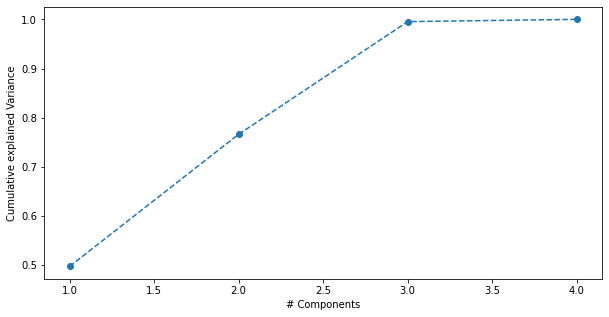

In [7]:
plt.figure(figsize=(10,5))
plt.plot(range(1,5), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('# Components')
plt.ylabel('Cumulative explained Variance')

In [8]:
pca = PCA(n_components=3)
pca.fit(df_std)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [9]:
pca.transform(df_std)

array([[-0.98626265,  1.71789179,  0.38042119],
       [ 1.98170109,  3.06572225,  2.01112212],
       [-0.62235286,  3.07934186,  1.76758224],
       ...,
       [-0.73525153,  1.17745359, -0.1328458 ],
       [-0.8611715 ,  1.73608505,  0.41190876],
       [ 0.26500843,  2.41814873,  1.19840862]])

In [10]:
scores_pca = pca.transform(df_std)

# K-means with PCA

In [17]:
%%time

vals = []
for i in range(1,20):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', n_jobs=-1)
    kmeans_pca.fit(scores_pca)
    vals.append(kmeans_pca.inertia_)

Wall time: 30.5 s


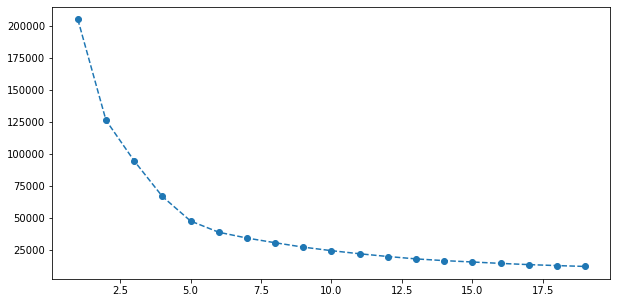

In [18]:
plt.figure(figsize=(10,5))
plt.plot(range(1,20), vals, marker='o', linestyle='--')

In [19]:
scores_pca

array([[-0.98626265,  1.71789179,  0.38042119],
       [ 1.98170109,  3.06572225,  2.01112212],
       [-0.62235286,  3.07934186,  1.76758224],
       ...,
       [-0.73525153,  1.17745359, -0.1328458 ],
       [-0.8611715 ,  1.73608505,  0.41190876],
       [ 0.26500843,  2.41814873,  1.19840862]])

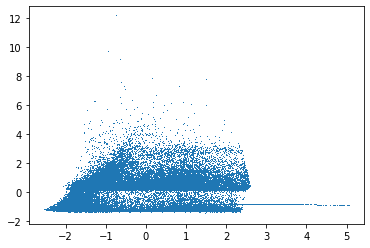

In [20]:
plt.plot(scores_pca[:, 0], scores_pca[:, 1], ',')

# References
1. [K-Means](https://realpython.com/k-means-clustering-python/#partitional-clustering) Clustering in Python and PCA (Real Python).
2. Practical [Text Classification](https://realpython.com/python-keras-text-classification/) With Python and Keras.
3. [PCA](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60) using python.